I dati utilizzati in questo notebook sono stati presi dalla competizione di Analytics Vidhya [Practice Problem: Big Mart Sales III](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#data_dictionary).

# Analisi esplorativa e preprocessamento dei dati

## Indice

1. [Big Mart Sales](#big_mart_sales)<br>
    1.1 [Descrizione](#descrizione)<br>
    1.2 [Leggere i dati e separare la variabile risposta](#leggere_dati)<br>
2. [Analisi esplorativa: studiare le variabili esplicative](#studiare_esplicative)<br>
    2.1 [Contare i valori mancanti](#contare_valori_mancanti)<br>
    2.2 [Dividere le variabili quantitative dalle variabili qualitative](#dividere_quantitative_qualitative)<br>
    2.3 [Variabili quantitative](#quantitative)<br>
    2.4 [Variabili qualitative](#qualitative)<br>
3. [Preprocessare i dati](#preprocessare_dati)<br>
    3.1 [Riempire i valori mancanti](#riempire_valori_mancanti)<br>
    3.2 [Aggregare i livelli simili delle variabili qualitative](#aggregare_livelli_qualitative)<br>
    3.3 [Eliminare le colonne che non si intendono utilizzare](#eliminare_colonne)<br>
4. [Ottenere gli indici degli insiemi di *training*, *validation* e *test*](#train_val_test)<br>
5. [Analisi esplorativa: studiare la relazione tra variabili esplicative e variabile risposta](#studiare_esplicative_risposta)<br>
    5.1 [Relazione tra quantitative e risposta](#quantitative_risposta)<br>
    5.2 [Relazione tra qualitative e risposta](#qualitative_risposta)<br>
    5.3 [Relazione tra esplicative e risposta](#esplicative_risposta)<br>
6. [Trasformare le variabili qualitative in dummy](#dummy)<br>
7. [Standardizzare i dati](#standardizzare)<br>
8. [Pipeline di preprocessamento](#pipeline)<br>
    8.1 [Definire una `Pipeline`](#definire_pipeline)<br>
    8.2 [Preprocessare i dati attraverso la pipeline](#preprocessare_pipeline)<br>
9. [Salvare](#salvare)<br>
    9.1 [Salvare i dati preprocessati](#salvare_dati)<br>
    9.2 [Salvare la pipeline](#salvare_pipeline)<br>

In [2]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# 1. Big Mart Sales <a id=big_mart_sales> </a>

## 1.1 Descrizione <a id=descrizione> </a>

### Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

 

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

### Data

We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

|**Variable**                 | Description                                              |
|-----------------------------|----------------------------------------------------------|
|**Item_Identifier**          | Unique product ID                                        |
|**Item_Weight**              | Weight of product                                        |
|**Item_Fat_Content**         | Whether the product is low fat or not                    |
|**Item_Visibility**          | The % of total display area of all products in a store allocated<br/>to the particular product|
|**Item_Type**                |The category to which the product belongs                 |
|**Item_MRP**                 |Maximum Retail Price (list price) of the product          |
|**Outlet_Identifier**        |Unique store ID                                           |
|**Outlet_Establishment_Year**|The year in which store was established                   |
|**Outlet_Size**              |The size of the store in terms of ground area covered     |
|**Outlet_Location_Type**     |The type of city in which the store is located            |
|**Outlet_Type**              |Whether the outlet is just a grocery store or some sort of<br/>supermarket|
|**Item_Outlet_Sales**        |Sales of the product in the particular store. This is the outcome variable<br/>to be predicted|

## 1.2 Leggere i dati e separare la variabile risposta <a id=leggere_dati> </a>

### Leggere i dati

In [3]:
PATH = "msbd/datasets/big_mart_sales" # cambiare in base a dove si è salvato il dataset

dati = pd.read_csv(PATH + "/Train_UWu5bXk.csv")
print("Dimensione del dataset: {} x {}".format(*dati.shape))
dati.head()

Dimensione del dataset: 8523 x 12


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Dividere le variabili esplicative dalla variabile risposta

In [4]:
risposta = "Item_Outlet_Sales"
esplicative = sorted(col for col in dati.columns if col != risposta)

X, y = dati[esplicative].copy(), dati[risposta].copy()

# 2. Analisi esplorativa: studiare le variabili esplicative <a id=studiare_esplicative> </a>

## 2.1 Contare i valori mancanti <a id=contare_valori_mancanti> </a>

In [5]:
dati.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## 2.2 Dividere le variabili quantitative dalle variabili qualitative <a id=dividere_quantitative_qualitative> </a>

### Controllare i `dtypes` delle colonne

In [6]:
X.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
dtype: object

### Salvare i nomi delle colonne in due liste distinte

In [7]:
quantitative = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
qualitative = X.select_dtypes(include=["object"]).columns.tolist()

## 2.3 Variabili quantitative <a id=quantitative> </a>

In [8]:
X[quantitative].head()

,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year
0,249.8092,0.016047,9.30,1999
1,48.2692,0.019278,5.92,2009
2,141.6180,0.016760,17.50,1999
3,182.0950,0.000000,19.20,1998
4,53.8614,0.000000,8.93,1987


### Descrivere le variabili

In [9]:
X.describe() # nota: vengono automaticamente considerate solo le colonne numeriche

,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,8523.000000,8523.000000,7060.000000,8523.000000
mean,140.992782,0.066132,12.857645,1997.831867
std,62.275067,0.051598,4.643456,8.371760
min,31.290000,0.000000,4.555000,1985.000000
25%,93.826500,0.026989,8.773750,1987.000000
50%,143.012800,0.053931,12.600000,1999.000000
75%,185.643700,0.094585,16.850000,2004.000000
max,266.888400,0.328391,21.350000,2009.000000


<Figure size 720x720 with 0 Axes>

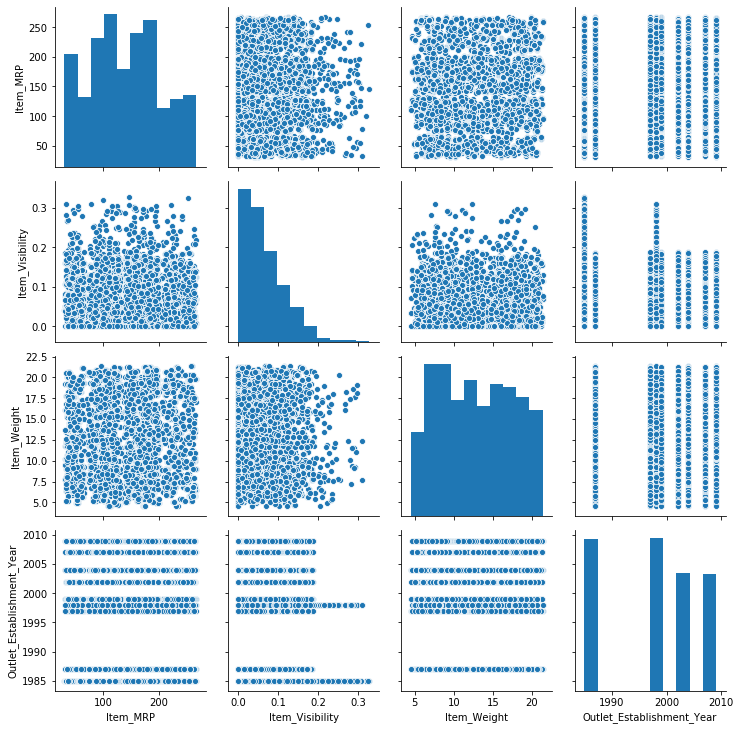

In [10]:
plt.figure(figsize=(10, 10))

sns.pairplot(X[quantitative])

plt.show()

## 2.4 Variabili qualitative <a id=qualitative> </a>

In [11]:
X[qualitative].head()

,Item_Fat_Content,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type
0,Low Fat,FDA15,Dairy,OUT049,Tier 1,Medium,Supermarket Type1
1,Regular,DRC01,Soft Drinks,OUT018,Tier 3,Medium,Supermarket Type2
2,Low Fat,FDN15,Meat,OUT049,Tier 1,Medium,Supermarket Type1
3,Regular,FDX07,Fruits and Vegetables,OUT010,Tier 3,NaN,Grocery Store
4,Low Fat,NCD19,Household,OUT013,Tier 3,High,Supermarket Type1


### Contare il numero di livelli

In [12]:
X[qualitative].nunique()

Item_Fat_Content           5
Item_Identifier         1559
Item_Type                 16
Outlet_Identifier         10
Outlet_Location_Type       3
Outlet_Size                3
Outlet_Type                4
dtype: int64

### Contare il numero di osservazioni per ogni livello

In [13]:
for col in qualitative:
    print("Variabile {}".format(col))
    display(X[col].value_counts().head(16)) # mi limito ai primi 16 valori di ogni livello

Variabile Item_Fat_Content


Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Variabile Item_Identifier


FDG33    10
FDW13    10
FDT07     9
FDP25     9
FDF56     9
FDW26     9
FDV60     9
FDO19     9
NCI54     9
NCB18     9
NCJ30     9
FDU12     9
FDQ40     9
NCY18     9
DRE49     9
FDX04     9
Name: Item_Identifier, dtype: int64

Variabile Item_Type


Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Variabile Outlet_Identifier


OUT027    935
OUT013    932
OUT049    930
OUT035    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

Variabile Outlet_Location_Type


Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Variabile Outlet_Size


Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Variabile Outlet_Type


Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

### Esercizio

Esplorare ulteriormente per via grafica le variabili esplicative (istogrammi, boxplot, ...).

> Suggerimento: considerare le librerie [Matplotlib](https://matplotlib.org/) o [Seaborn](https://seaborn.pydata.org/).

<Figure size 864x720 with 0 Axes>

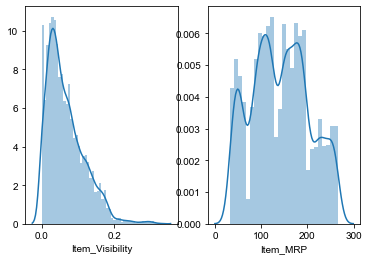

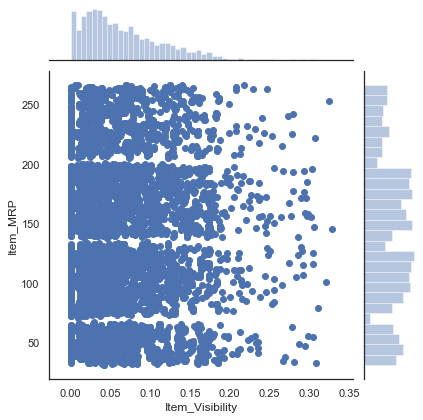

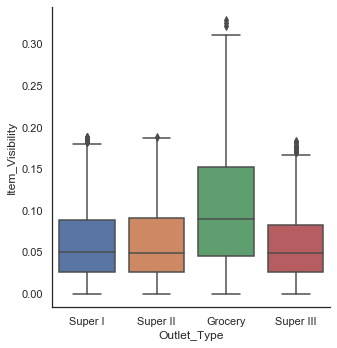

In [14]:
import seaborn as sns

plt.figure(figsize=(12, 10))

## libreria seaborn
# Esempio 1 - istogramma e funzione di densità
fig, ax = plt.subplots(1,2)
sns.distplot(X["Item_Visibility"], ax=ax[0])
sns.distplot(X["Item_MRP"], ax=ax[1])
fig.show()

# Esempio 2 - jointplot: scatterplot + istogrammi delle marginali
sns.set(style="white", color_codes=True)
g12 = sns.jointplot(x=X["Item_Visibility"], y=X["Item_MRP"], data=X)

# Esempio 3 - boxplot (variabile continua vs variabile categoriale)
sns.catplot(x="Outlet_Type", y="Item_Visibility", kind="box", data=X).set_xticklabels(["Super I", "Super II", "Grocery", "Super III"])


# 3. Preprocessare i dati <a id=preprocessare_dati> </a>

## 3.1 Riempire i valori mancanti <a id=riempire_valori_mancanti> </a>

### Studiare la relazione tra *Item_Identifier* e *Item_Weight*

In [15]:
weight_grby_id = X[["Item_Identifier", "Item_Weight"]].groupby("Item_Identifier").\
    agg(["count", "min", "max"])["Item_Weight"]
weight_grby_id.sort_values("count", inplace=True, ascending=False)

print("Item_Identifier senza nemmeno un Item_Weight associato: {}".format((weight_grby_id["count"] == 0).sum()))
weight_grby_id = weight_grby_id.loc[weight_grby_id["count"] > 0]
print("Percentuale di Item_Identifier con almeno un Item_Weight per cui min è uguale a max: {}%"
      .format(100 * (weight_grby_id["min"] == weight_grby_id["min"]).mean()))
display(weight_grby_id.head(10))

Item_Identifier senza nemmeno un Item_Weight associato: 4
Percentuale di Item_Identifier con almeno un Item_Weight per cui min è uguale a max: 100.0%


,count,min,max
Item_Identifier,,,
FDG09,8,20.600,20.600
NCY18,8,7.285,7.285
DRE49,8,20.750,20.750
NCJ30,8,5.820,5.820
DRN47,8,12.100,12.100
FDW13,8,8.500,8.500
FDL58,8,5.780,5.780
FDP28,8,13.650,13.650
FDG57,8,14.700,14.700


### Riempire i valori mancanti di *Item_Weight*

In [16]:
from msbd.preprocessamento import RiempireNAItemWeight

print(inspect.getsource(RiempireNAItemWeight))

class RiempireNAItemWeight(TransformerMixin):
    """Riempie i valori mancanti di 'Item_Weight'

    Attributes
    ----------
    weight_dict_ : dict
        Dizionario che associa ad ogni 'Item_Identifier' il suo
        'Item_Weight' medio.

    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.weight_dict_ = X[["Item_Identifier", "Item_Weight"]].groupby(
            "Item_Identifier").mean()["Item_Weight"].to_dict()

        return self

    def transform(self, X):
        check_is_fitted(self, "weight_dict_")

        value = {idx : self.weight_dict_.get(identifier) for idx, identifier in
            zip(X.index, X["Item_Identifier"])}

        X["Item_Weight"].fillna(value, inplace=True)

        return X



In [17]:
# cosa succede nei metodi di RiempireNAItemWeight?

# calcolo la media di Item_Weight aggregata su Item_Identifier
dizionario_peso_medio = X[["Item_Identifier", "Item_Weight"]].groupby("Item_Identifier").mean()["Item_Weight"].to_dict()

# lookup su dizionario_peso_medio dell'indice corrispondente all'item di ciascun record di X:
valore = {idx : dizionario_peso_medio.get(identifier) for idx, identifier in
            zip(X.index, X["Item_Identifier"])}

print("Dizionario con i pesi medi di ogni articolo univoco (primi record)")
for i, (key, val) in enumerate(dizionario_peso_medio.items()):
    if i<=5:
        print(key, val)

print("\nDizionario con i pesi medi per ogni articolo di X")
for key, val in valore.items():
    if key<=5:
        print(key, val)

Dizionario con i pesi medi di ogni articolo univoco (primi record)
DRA12 11.6
DRA24 19.35
DRA59 8.269999999999998
DRB01 7.39
DRB13 6.115
DRB24 8.785

Dizionario con i pesi medi per ogni articolo di X
0 9.299999999999999
1 5.92
2 17.5
3 19.2
4 8.93
5 10.395


In [18]:
print("Valori mancanti di Item_Weight prima della sostituzione: {}".format(X["Item_Weight"].isnull().sum()))

riempire_na_item_weight = RiempireNAItemWeight()

X = riempire_na_item_weight.fit_transform(X)

print("Valori mancanti di Item_Weight dopo la sostituzione: {}".format(X["Item_Weight"].isnull().sum()))

Valori mancanti di Item_Weight prima della sostituzione: 1463
Valori mancanti di Item_Weight dopo la sostituzione: 4


### Studiare la relazione tra *Outlet_Location_Type* e *Outlet_Size*

In [19]:
size_grby_location = X.groupby("Outlet_Location_Type")["Outlet_Size"].value_counts().unstack().fillna(0)

size_grby_location

Outlet_Size,High,Medium,Small
Outlet_Location_Type,,,
Tier 1,0.0,930.0,1458.0
Tier 2,0.0,0.0,930.0
Tier 3,932.0,1863.0,0.0


### Studiare la relazione tra *Outlet_Type* e *Outlet_Size*

In [20]:
size_grby_type = X.groupby("Outlet_Type")["Outlet_Size"].value_counts().unstack().fillna(0)

size_grby_type

Outlet_Size,High,Medium,Small
Outlet_Type,,,
Grocery Store,0.0,0.0,528.0
Supermarket Type1,932.0,930.0,1860.0
Supermarket Type2,0.0,928.0,0.0
Supermarket Type3,0.0,935.0,0.0


### Riempire i valori mancanti di *Outlet_Size*

In [21]:
from msbd.preprocessamento import RiempireNAOutletSize

print(inspect.getsource(RiempireNAOutletSize))

class RiempireNAOutletSize(TransformerMixin):
    """Riempie i valori mancanti di 'Outlet_Size'"""
    def __init__(self):
        pass

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        is_null = X["Outlet_Size"].isnull()
        is_tier2 = X["Outlet_Location_Type"] == "Tier 2"
        is_grocery = X["Outlet_Type"] == "Grocery Store"
        is_type2 = X["Outlet_Type"] == "Supermarket Type2"
        is_type3 = X["Outlet_Type"] == "Supermarket Type3"
        X.loc[is_null & (is_tier2 | is_grocery), "Outlet_Size"] = "Small"
        X.loc[is_null & (is_tier2 | is_grocery), "Outlet_Size"] = "Small"
        X.loc[is_null & is_type2, "Outlet_Size"] = "Medium"
        X.loc[is_null & is_type3, "Outlet_Size"] = "Medium"

        return X



In [22]:
print("Valori mancanti di Outlet_Size prima della sostituzione: {}".format(X["Outlet_Size"].isnull().sum()))

riempire_na_outlet_size = RiempireNAOutletSize()

X = riempire_na_outlet_size.fit_transform(X)

print("Valori mancanti di Outlet_Size dopo della sostituzione: {}".format(X["Outlet_Size"].isnull().sum()))

Valori mancanti di Outlet_Size prima della sostituzione: 2410
Valori mancanti di Outlet_Size dopo della sostituzione: 0


### Riempire gli ultimi valori mancanti rimasti delle variabili quantitative utilizzando il valor medio

In [23]:
from msbd.preprocessamento import RiempireNAMedia

print(inspect.getsource(RiempireNAMedia))

class RiempireNAMedia(TransformerMixin):
    """Riempie i valori mancanti utilizzando la media

    Attributes
    ----------
    media_dict_ : dict
        Dizionario che associa ad ogni colonna il suo valore medio.

    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # DataFrame.mean() ha come default numeric_only=True
        self.media_dict_ = X.mean().to_dict()

        return self

    def transform(self, X):
        check_is_fitted(self, "media_dict_")

        return X.fillna(self.media_dict_)



In [24]:
print("Valori mancanti prima della sostituzione: \n{}".format(X.isnull().sum()))

riempire_na_media = RiempireNAMedia()

X = riempire_na_media.fit_transform(X)

print("\nValori mancanti dopo la sostituzione: \n{}".format(X.isnull().sum()))

Valori mancanti prima della sostituzione: 
Item_Fat_Content             0
Item_Identifier              0
Item_MRP                     0
Item_Type                    0
Item_Visibility              0
Item_Weight                  4
Outlet_Establishment_Year    0
Outlet_Identifier            0
Outlet_Location_Type         0
Outlet_Size                  0
Outlet_Type                  0
dtype: int64

Valori mancanti dopo la sostituzione: 
Item_Fat_Content             0
Item_Identifier              0
Item_MRP                     0
Item_Type                    0
Item_Visibility              0
Item_Weight                  0
Outlet_Establishment_Year    0
Outlet_Identifier            0
Outlet_Location_Type         0
Outlet_Size                  0
Outlet_Type                  0
dtype: int64


## 3.2 Aggregare i livelli simili delle variabili qualitative <a id=aggregare_livelli_qualitative> </a>

### Aggregare i livelli simili di *Item_Fat_Content*

In [25]:
from msbd.preprocessamento import Sostituire

print(inspect.getsource(Sostituire))

class Sostituire(TransformerMixin):
    """Sostituisce i valori di un DataFrame in base a un dizionario

    Parameters
    ----------
    to_replace : dict
        Dizionario innestato, es., {"a": {"b": "c"}}, si legge come:
        cerca nella colonna "a" il valore "b" e sostituiscilo con "c".
    """
    def __init__(self, to_replace):
        self.to_replace = to_replace

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        X.replace(self.to_replace, inplace=True)

        return X



In [26]:
to_replace = {"Item_Fat_Content": {"Low Fat": "Low_Fat", "LF": "Low_Fat", "low fat": "Low_Fat", "reg": "Regular"}}

In [27]:
print("Livelli prima della sostituzione: {}".format(X["Item_Fat_Content"].unique()))

sostituire_item_fat_content = Sostituire(to_replace)

X = sostituire_item_fat_content.fit_transform(X)

print("Livelli dopo la sostituzione: {}".format(X["Item_Fat_Content"].unique()))

Livelli prima della sostituzione: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Livelli dopo la sostituzione: ['Low_Fat' 'Regular']


## 3.3 Eliminare le colonne che non si intendono utilizzare <a id=eliminare_colonne> </a>

### Eliminare *Item_Identifier*

In [28]:
from msbd.preprocessamento import Eliminare

print(inspect.getsource(Eliminare))

class Eliminare(TransformerMixin):
    """Elimina le colonne specificate da un DataFrame

    Parameters
    ----------
    columns : singola string o list-like
        Colonne da eliminare.
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        return X.drop(columns=self.columns)



In [29]:
elim = Eliminare("Item_Identifier")

X = elim.fit_transform(X)

esplicative.remove("Item_Identifier")
qualitative.remove("Item_Identifier")

# 4. Ottenere gli indici degli insiemi di *training*, *validation* e *test* <a id=train_val_test> </a>

In [30]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(y.index.values, test_size=1000, random_state=42)
idx_train, idx_val = train_test_split(idx_train, test_size=1000, random_state=42)

print("Dimensione del training set: {}".format(len(idx_train)))
print("Dimensione del validation set: {}".format(len(idx_val)))
print("Dimensione del test set: {}".format(len(idx_test)))

Dimensione del training set: 6523
Dimensione del validation set: 1000
Dimensione del test set: 1000


# 5. Analisi esplorativa: studiare la relazione tra variabili esplicative e variabile risposta <a id=studiare_esplicative_risposta> </a>

<div class="alert alert-danger fade in">
<strong>IMPORTANTE</strong>: Le analisi relative (anche) alla variabile risposta vanno effettuate utilizzando solo l'insieme di <em>training</em>. Utilizzare in questa fase anche gli insiemi di <em>validation</em> e/o di <em>test</em> può inficiare in modo più o meno grave le conclusioni che si traggono su di essi.
</div>

## 5.1 Relazione tra quantitative e risposta <a id=quantitative_risposta> </a>

In [31]:
from msbd.grafici import grafico_dispersione_quantitative_risposta

print(inspect.getsource(grafico_dispersione_quantitative_risposta))

def grafico_dispersione_quantitative_risposta(X, y, quantitative, n_columns):
    """Grafici di dispersione tra quantitative e risposta"""
    n_var = len(quantitative)

    for i, var in enumerate(quantitative):
        plt.subplot(math.ceil(n_var / n_columns), n_columns, i + 1)
        sns.regplot(X[var], y=y, line_kws={"color": "orange", "ls": "--"})
        plt.tight_layout()
        plt.grid()



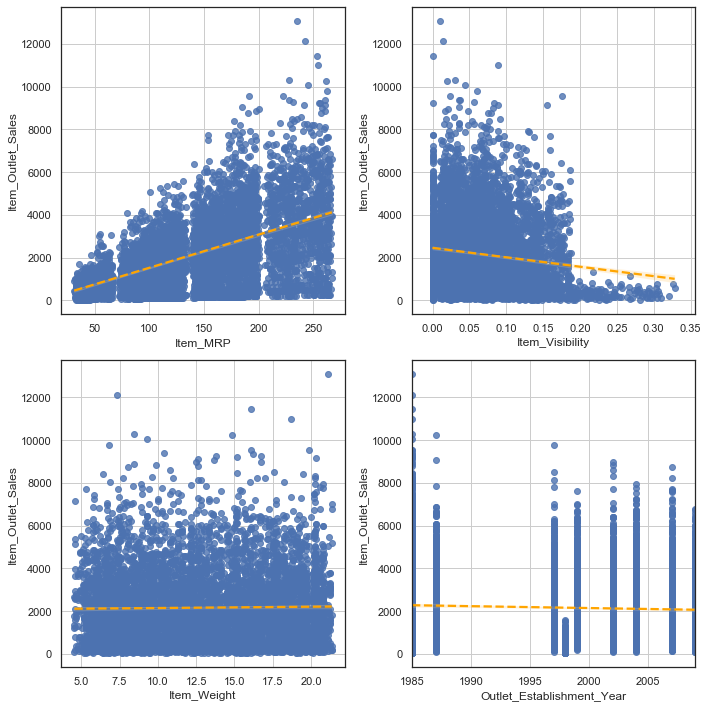

In [32]:
plt.figure(figsize=(10, 10))

grafico_dispersione_quantitative_risposta(X.loc[idx_train], y.loc[idx_train], quantitative, 2)

plt.show()

## 5.2 Relazione tra qualitative e risposta <a id=qualitative_risposta> </a>

In [33]:
from msbd.grafici import grafico_barre_qualitative_risposta

print(inspect.getsource(grafico_barre_qualitative_risposta))

def grafico_barre_qualitative_risposta(X, y, qualitative, n_columns):
    """Grafico a barre della relazione tra qualitative e risposta"""
    n_var = len(qualitative)

    for i, var in enumerate(qualitative):
        ax = plt.subplot(math.ceil(n_var / n_columns), n_columns, i + 1)
        pd.concat([X[var], y], axis=1).groupby(var).mean().plot(ax=ax,
            kind='bar')
        plt.tight_layout()
        plt.grid()



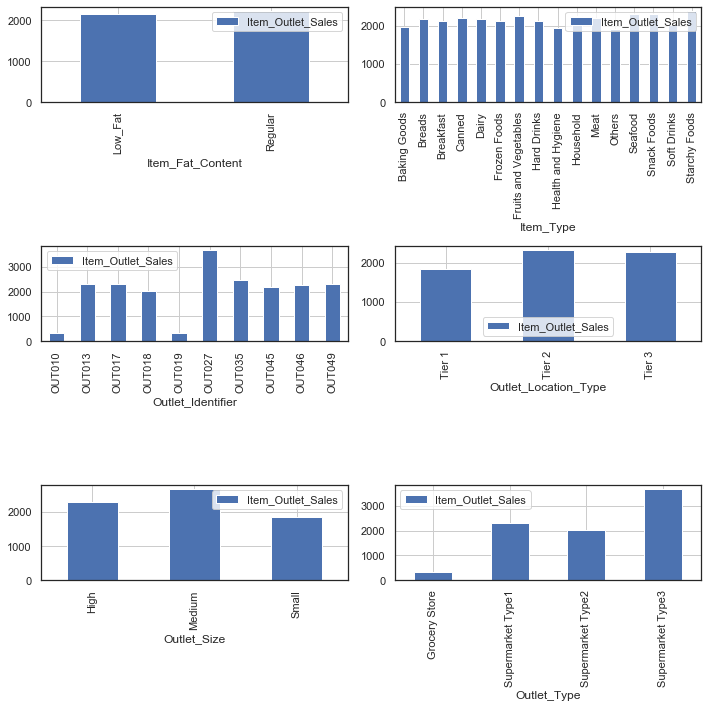

In [34]:
plt.figure(figsize=(10, 10))

grafico_barre_qualitative_risposta(X.loc[idx_train], y.loc[idx_train], qualitative, 2)

plt.show()

## 5.3 Relazione tra esplicative e risposta <a id=esplicative_risposta> </a>

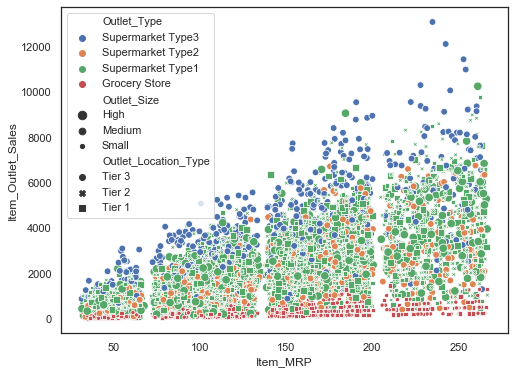

In [35]:
# Versione "compressa" con 3 variabili categoriali

plt.figure(figsize=(8, 6))

sns.scatterplot(X.loc[idx_train, "Item_MRP"], y=y.loc[idx_train],
                hue=X.loc[idx_train, "Outlet_Type"],
                hue_order=["Supermarket Type3", "Supermarket Type2", "Supermarket Type1", "Grocery Store"],
                style=X.loc[idx_train, "Outlet_Location_Type"],
                style_order=["Tier 3", "Tier 2", "Tier 1"],
                size=X.loc[idx_train, "Outlet_Size"],
                size_order=["High", "Medium", "Small"])
plt.show()

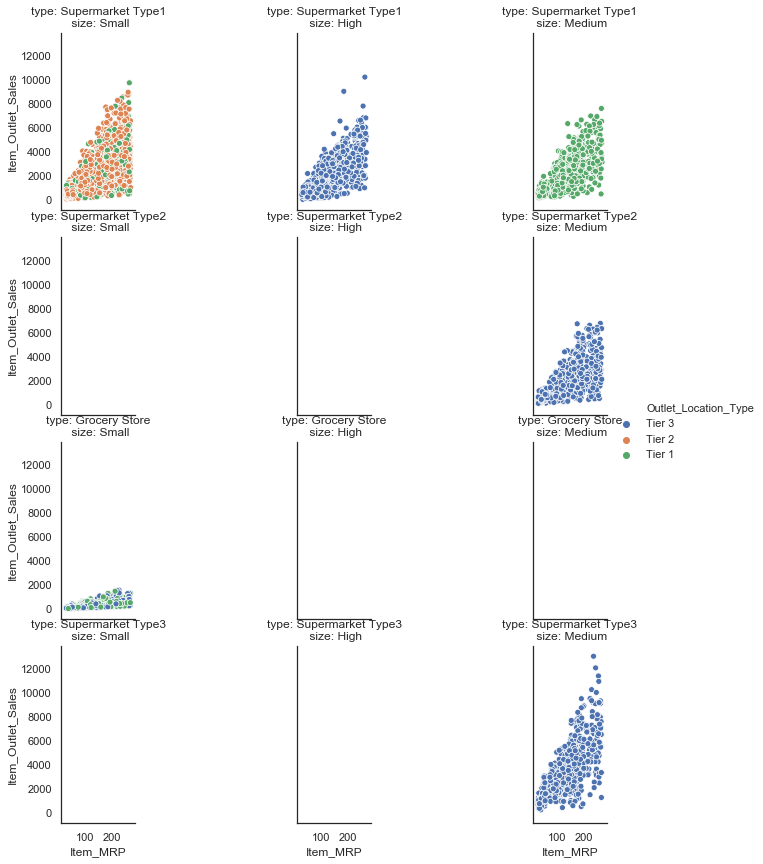

In [36]:
# Versione con griglia di grafici ed una variabile categoriale (colore) per grafico

g = sns.FacetGrid(pd.concat([X, y], axis=1).loc[idx_train,:], row="Outlet_Type", col="Outlet_Size")
g = (g.map(sns.scatterplot, "Item_MRP", "Item_Outlet_Sales", hue = X.loc[idx_train, "Outlet_Location_Type"], hue_order = ["Tier 3", "Tier 2", "Tier 1"])
     .add_legend().set_titles("type: {row_name}\n size: {col_name}"))


# 6. Trasformare le variabili qualitative in dummy <a id=dummy> </a>

In [37]:
from msbd.preprocessamento import OttenereDummy

print(inspect.getsource(OttenereDummy))

class OttenereDummy(TransformerMixin):
    """Trasforma le variabili con dtype 'object' or 'category' in dummy

    Parameters
    ----------
    drop_first : bool, default False
        Se ottenere k-1 dummy da k livelli categoriali attraverso la
        rimozione del primo livello.

    Attributes
    ----------
    columns_ : Index
        Colonne del DataFrame a seguito della trasformazione.

    """
    def __init__(self, drop_first=False):
        self.drop_first = drop_first

    def fit(self, X, y=None):
        # TODO: ottenere self.columns_ senza utilizzare get_dummies()
        # ============== YOUR CODE HERE ==============
        self.columns_ = pd.get_dummies(X, drop_first=self.drop_first).columns
        # ============================================

        return self

    def transform(self, X):
        check_is_fitted(self, "columns_")

        X = pd.get_dummies(X)
        X = X.reindex(columns=self.columns_, fill_value=0)

        return X.astype(float)



### Esercizio

Per come è definito, il metodo `fit()` della classe `OttenereDummy` crea le variabili dummy solo per salvarne i nomi. Ottenere lo stesso risultato senza utilizzare la funzione `get_dummies()` e senza creare le dummy in `fit()` (le dummy verranno create in `transform()`).

In [38]:
# un suggerimento...
X2 = X.copy()

print("Colonne originali: {}\n".format(X2.columns))

for j, tipo in enumerate(X2.dtypes):
    if tipo == "object":
        print("Da completare")
        #nome_campo = ...
        #valori_distinti = np.sort(...)
        #nomi_campo_dummies = [nome_campo + valore_distinto for valore_distinto in valori_distinti]
        #print("{} -> {}".format(nome_campo, nomi_campo_dummies[1:]))

Colonne originali: Index(['Item_Fat_Content', 'Item_MRP', 'Item_Type', 'Item_Visibility',
       'Item_Weight', 'Outlet_Establishment_Year', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type'],
      dtype='object')

Da completare
Da completare
Da completare
Da completare
Da completare
Da completare


In [39]:
print("X prima della creazione delle variabili dummy:")
display(X.head(2))

od = OttenereDummy(drop_first=True)

X = od.fit_transform(X)

print("\nX dopo la creazione delle variabili dummy:")
X.head(2)

X prima della creazione delle variabili dummy:


,Item_Fat_Content,Item_MRP,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type
0,Low_Fat,249.8092,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1
1,Regular,48.2692,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2



X dopo la creazione delle variabili dummy:


,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,249.8092,0.016047,9.30,1999.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,48.2692,0.019278,5.92,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


### Esercizio

Perché abbiamo scelto `drop_first=True`?

# 7. Standardizzare i dati <a id=standardizzare> </a>

In [40]:
from msbd.preprocessamento import Standardizzare

print(inspect.getsource(Standardizzare))

class Standardizzare(TransformerMixin):
    """Standardizza i dati rimuovendo la media e dividendo per la
    deviazione standard

    Parameters
    ----------
    con_media : ...

    con_dev_std : ...

    Attributes
    ----------
    media_ : ...

    dev_std_ : ...
    """
    def __init__(self, con_media=True, con_dev_std=True):
        self.con_media = con_media
        self.con_dev_std = con_dev_std

    def fit(self, X, y=None):
        if self.con_media:
            self.media_ = X.mean()
        else:
            self.media_ = None

        if self.con_dev_std:
            self.dev_std_ = X.std()
        else:
            self.dev_std_ = None

        return self

    def transform(self, X):
        check_is_fitted(self, ["media_", "dev_std_"])

        if self.con_media:
            X -= self.media_

        if self.con_dev_std:
            X /= self.dev_std_

        return X

    def inverse_transform(self, X):
        check_is_fitted(self, ["media_", "dev_std_"])

     

In [41]:
X2 = X.copy()

print("X prima della standardizzazione:")
display(X.head(2))

std = Standardizzare()

X = std.fit_transform(X)

print("X dopo la standardizzazione:")
X.head(2)

X prima della standardizzazione:


,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,249.8092,0.016047,9.30,1999.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,48.2692,0.019278,5.92,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


X dopo la standardizzazione:


,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,1.747351,-0.970675,-0.769734,0.139533,-0.738104,-0.174183,-0.114339,-0.287078,3.390534,-0.334117,...,-0.349741,-0.349953,2.857194,-0.696637,-0.804685,1.432242,-1.134858,0.726759,-0.349530,-0.351008
1,-1.488936,-0.908058,-1.497397,1.334024,1.354664,-0.174183,-0.114339,-0.287078,-0.294904,-0.334117,...,-0.349741,-0.349953,-0.349953,-0.696637,1.242577,1.432242,-1.134858,-1.375810,2.860648,-0.351008


### Esercizio

1. Completare il metodo `inverse_transform()` della classe `Standardizzare`;
2. Verificare il corretto funzionamento di `inverse_transform()` utilizzando `pytest`.

In [ ]:
std = Standardizzare()

print("DataFrame originale (prime 2 colonne): \n {}".format(X2.iloc[:,:2].head()))

X2_trs = std.fit(X2).transform(X2.copy())
print("\nDataFrame trasformato (prime 2 colonne): \n {}".format(X2_trs.iloc[:,:2].head()))

X2_orig = std.fit(X2).inverse_transform(X2_trs.copy())
print("\nDataFrame ricostruito: (prime 2 colonne): \n {}".format(X2_orig.iloc[:,:2].head()))

In [ ]:
!pytest -v msbd/tests/test_trasformazione_fit.py -p no:warnings

# 8. Pipeline di preprocessamento <a id=pipeline> </a>

In [ ]:
from sklearn.pipeline import Pipeline

## 8.1 Definire una `Pipeline` <a id=definire_pipeline> </a>

In [ ]:
preproc = Pipeline([
    ("riempire_na_item_weight", RiempireNAItemWeight()),
    ("riempire_na_outlet_size", RiempireNAOutletSize()),
    ("riempire_na_media", RiempireNAMedia()),
    ("eliminare_item_identifier", Eliminare(columns="Item_Identifier")),
    ("ottenere_dummy", OttenereDummy(drop_first=True)),
    ("standardizzare", Standardizzare()),
])

## 8.2 Preprocessare i dati attraverso la pipeline <a id=preprocessare_pipeline> </a>

In [ ]:
risposta = "Item_Outlet_Sales"
esplicative = sorted(col for col in dati.columns if col != risposta)

X, y = dati[esplicative].copy(), dati[risposta].copy()

In [ ]:
print("Dati grezzi:")
display(X.head(2))

X_preproc = preproc.fit_transform(X)

print("Dati preprocessati:")
X_preproc.head(2)

### Esercizio

Verificare che la pipeline costruita applichi tutte le trasformazioni viste in questo notebook, confrontando il risultato ottenuto con `X_preproc` (mediante l'utilizzo del metodo `np.allclose`).

# 9. Salvare <a id=salvare> </a>

In [ ]:
OUTPUT_DIR = "msb/output/07"

os.makedirs(OUTPUT_DIR, exist_ok=True) # se non esiste, crea la cartella finale e tutte le intermedie

## 9.1 Salvare i dati preprocessati <a id=salvare_dati> </a>

In [ ]:
X_preproc.loc[idx_train].to_pickle(OUTPUT_DIR + "/X_train.pkl")
X_preproc.loc[idx_val].to_pickle(OUTPUT_DIR + "/X_val.pkl")
X_preproc.loc[idx_test].to_pickle(OUTPUT_DIR + "/X_test.pkl")
y.loc[idx_train].to_pickle(OUTPUT_DIR + "/y_train.pkl")
y.loc[idx_val].to_pickle(OUTPUT_DIR + "/y_val.pkl")
y.loc[idx_test].to_pickle(OUTPUT_DIR + "/y_test.pkl")

## 9.2 Salvare la pipeline <a id=salvare_pipeline> </a>

In [ ]:
from sklearn.externals import joblib

joblib.dump(preproc, OUTPUT_DIR + "/preproc.joblib")